In [1]:
import os
import gzip
import numpy as np
from sklearn.linear_model import *

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
# data_dir="/Users/michellehu/git_dirs/ComplexSystems_AMATH563/data/"
data_dir="/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/data/"
if ~os.path.exists(data_dir):
    !mkdir $data_dir

mkdir: cannot create directory ‘/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/data/’: File exists


## Preprocessing and dataset exploration

In [3]:
# Download data if you haven't already
gz_fns=["t10k-labels-idx1-ubyte.gz", 
        "t10k-images-idx3-ubyte.gz", 
        "train-labels-idx1-ubyte.gz", 
        "train-images-idx3-ubyte.gz"]
data_paths=[data_dir + gz for gz in gz_fns]
data_sources=["http://yann.lecun.com/exdb/mnist/" + gz for gz in gz_fns]
data_sources
for f, source in zip(data_paths, data_sources):
    if os.path.exists(f):
        print("Exists!")
    else:
        print("Missing", f)
        print("Downloading now...")
        !wget -O $f $source

Exists!
Exists!
Exists!
Exists!


In [4]:
# From https://github.com/daniel-e/mnist_octave/blob/master/mnist.py
def loadY(fnlabel):
    f = gzip.open(fnlabel, 'rb')
    f.read(8)
    return np.frombuffer(f.read(), dtype = np.uint8)

def loadX(fnimg):
    f = gzip.open(fnimg, 'rb')
    f.read(16)
    return np.frombuffer(f.read(), dtype = np.uint8).reshape((-1, 28*28))

# Unzip, reformat and reshape
trainX = loadX(data_dir+"train-images-idx3-ubyte.gz")
trainY = loadY(data_dir+"train-labels-idx1-ubyte.gz")
testX = loadX(data_dir+"t10k-images-idx3-ubyte.gz")
testY = loadY(data_dir+"t10k-labels-idx1-ubyte.gz")

In [5]:
# double check that these reshapings make sense
print(trainX[0].shape)
print(trainX[0].reshape(28,28).shape)
print("28*28 =", 28*28)

# Check sizes of train and test datasets and labels
print("train A:", trainX.shape)
print("train B:", trainY.shape)
print("test A:", testX.shape)
print("test B:", testY.shape)

(784,)
(28, 28)
28*28 = 784
train A: (60000, 784)
train B: (60000,)
test A: (10000, 784)
test B: (10000,)


In [6]:
# Look at class distribution
# http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/
print('Digits:  0 1 2 3 4 5 6 7 8 9')
print('labels: %s' % np.unique(trainY))
print('Class distribution: %s' % np.bincount(trainY))

Digits:  0 1 2 3 4 5 6 7 8 9
labels: [0 1 2 3 4 5 6 7 8 9]
Class distribution: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


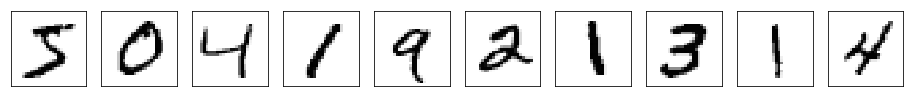

In [7]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trainX[i].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())

---

# Set up homework

In [8]:
# A is the vectorized MNIST training images
A=trainX.copy()
print(A.shape)

# B is the set of output vectors
B=trainY.copy()
print(B.shape)

(60000, 784)
(60000,)


### Question 1.

Using various AX=B solvers, determine a mapping from the image space (A) to the label space (B)

In [12]:
%%time
# # on local
# n_jobs=4

# on denali
n_jobs=4

# Instantiate logistic regression models. Tolerance set to 0.01 from initial 0.0001, takes half the time
tol=0.01

# without regularization
saga=LogisticRegression(solver="saga", C=1, n_jobs=n_jobs, tol=tol)

# with elasticnet regularization and saga solver
saga_elastic_L1=LogisticRegression(solver="saga",  C=0.01, penalty="elasticnet", l1_ratio=1, n_jobs=n_jobs, tol=tol)
saga_elastic_L2=LogisticRegression(solver="saga",  C=0.01, penalty="elasticnet", l1_ratio=0, n_jobs=n_jobs, tol=tol)
saga_elastic_mix=LogisticRegression(solver="saga",  C=0.01, penalty="elasticnet", l1_ratio=0.8, n_jobs=n_jobs, tol=tol)

# with stochastic gradient descent
sgd_elastic_L1=LogisticRegression(solver="sag", C=0.01, penalty="l1", n_jobs=n_jobs, tol=tol)
sgd_elastic_L2=LogisticRegression(solver="sag", C=0.01, penalty="l2", n_jobs=n_jobs, tol=tol)

solvers = [saga,
           saga_elastic_L1, 
           saga_elastic_L2,
           saga_elastic_mix,
           sgd_elastic_L1,
           sgd_elastic_L2
          ]

sparse_only = [ saga_elastic_L1, 
               saga_elastic_mix,
               sgd_elastic_L1,
              ]

CPU times: user 50 µs, sys: 4 µs, total: 54 µs
Wall time: 59.8 µs


In [16]:
def optimize(model, x_train, y_train, x_test, y_test, cv=None):
    '''
    model = model instance to use with specified solver, regularization etc.
    x = samples, features; these are observations (images) with # samples = # measurements and features being the attributes of that measurement
    y = samples; these are the _labels_ for the observations of same size as samples
    '''
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    score=model.score(x_test, y_test)
    
    if cv is not None:
        from sklearn.model_selection import cross_val_score
        # Run cv number of simulations using k-fold cross validation approach
        cv_scores=cross_val_score(model, x_train, y_train, cv=cv)
        return (model, predictions, score, cv_scores)    
    else:
        return (model, predictions, score)
    

def compute_loss(model, predictions, testX, testY):
    '''
    Assess model accuracy
    '''
    report=metrics.classification_report(testY, predictions)
    matrix=metrics.confusion_matrix(testY, predictions, normalize='true')
    return (report, matrix)


def plot_vip(trained_model):
    '''
    Check out very important pixels --> needs tweaking
    '''
    coef=trained_model.coef_
    coef=coef.reshape(10,28,28)
    cmin=coef.min()
    cmax=coef.max()

    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True)

    for i, ax in enumerate(axes.flat):
        ax.set_axis_off()
        im = ax.imshow(coef[i], vmin=cmin, vmax=cmax)
        ax.set_title(i)

    cb_ax=fig.add_axes([0.92, 0.1, 0.03, 0.8])
    cbar=fig.colorbar(im, cax=cb_ax)

## Test times without regularization and no cross-validation

In [15]:
%%time
trained_model, pred, acc = optimize(saga, A, B, testX, testY)
print("SAGA trained - no regularization, no cross-validation")

SAGA trained - no regularization, no cross-validation
CPU times: user 2min 32s, sys: 328 ms, total: 2min 33s
Wall time: 1min 39s


In [17]:
%%time
r, m = compute_loss(trained_model, pred, testX, testY)

CPU times: user 39.4 ms, sys: 56 µs, total: 39.5 ms
Wall time: 38.4 ms


In [20]:
print(r)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.91      0.87      0.89       892
           6       0.95      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.87      0.88      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



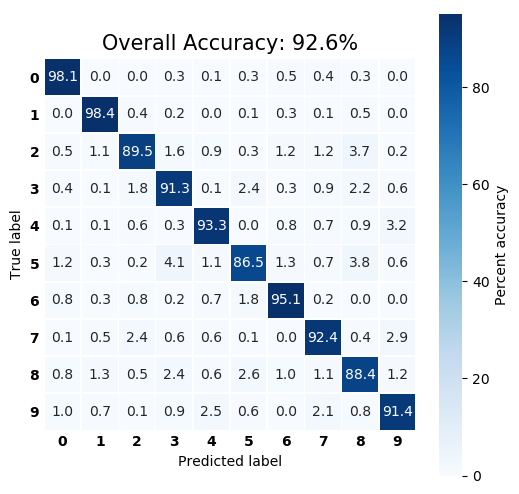

In [71]:
# Use seaborn to plot confusion matrix 
plt.figure(figsize=(6,6))
sns.heatmap(m*100, annot=True, fmt=".1f", 
            linewidths=.5, 
            square = True, 
            robust = True,
            cmap = 'Blues', 
            cbar_kws={'label': 'Percent accuracy'}, 
           );

plt.ylabel('True label');
plt.xlabel('Predicted label');

plt.xticks(weight="semibold");
plt.yticks(rotation=0, weight="semibold");

plt.tick_params(axis='both', which='both', length=0);

title = str('Overall Accuracy: '+ "{0:.1f}".format(acc*100)+"%")
plt.title(title, size = 15);

In [74]:
def plot_confusion(confusion_matrix, save_fn=None):
    '''
    Use seaborn to plot confusion matrix
    '''
    plt.figure(figsize=(6,6))
    sns.heatmap(confusion_matrix*100, annot=True, fmt=".1f", 
                linewidths=.5, 
                square = True, 
                robust = True,
                cmap = 'Blues', 
                cbar_kws={'label': 'Percent accuracy'}, 
               );

    plt.ylabel('True label');
    plt.xlabel('Predicted label');

    plt.xticks(weight="semibold");
    plt.yticks(rotation=0, weight="semibold");

    plt.tick_params(axis='both', which='both', length=0);

    title = str('Overall Accuracy: '+ "{0:.1f}".format(acc*100)+"%")
    plt.title(title, size = 15);

    if save_fn is not None:
        print("Saving as", save_fn)
        plt.savefig(save_fn, format='png', facecolor='white', edgecolor='none', dpi=300)

In [78]:
fig_dir = "/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/"

if ~os.path.exists(fig_dir):
    !mkdir $fig_dir
    
cm_fn=fig_dir+"hw1_test_confusionMatrix.png"
cm_fn

'/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_test_confusionMatrix.png'

Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_test_confusionMatrix.png


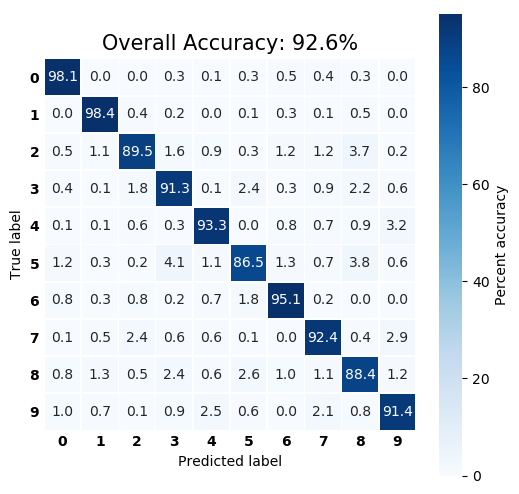

In [79]:
plot_confusion(m, save_fn=cm_fn)

## Test times with regularization and no cross-validation

SAGA trained with regularization - no cross-validation
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_test_confusionMatrix_saga_elastic_L1,noCV.png
CPU times: user 4min 49s, sys: 1.44 s, total: 4min 50s
Wall time: 4min 48s


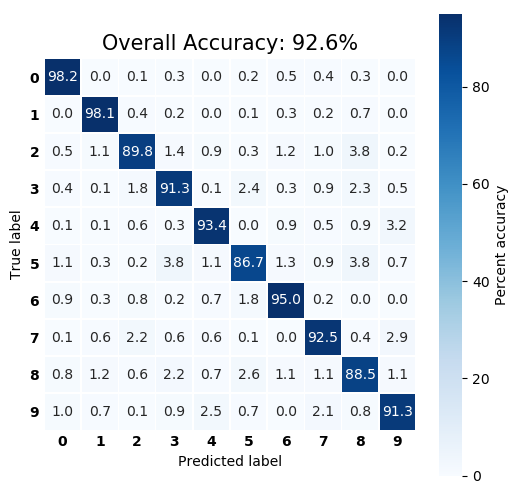

In [80]:
%%time

# test one model
trained_model, pred, acc = optimize(saga_elastic_L1, A, B, testX, testY)
print("SAGA trained with regularization - no cross-validation")

r, m = compute_loss(trained_model, pred, testX, testY)
print("Losses computed")

plot_confusion(m, save_fn=fig_dir+"hw1_test_confusionMatrix_saga_elastic_L1_noCV.png")

## Test times with regularization, no cross-validation and single digits

## Check out the most important pixels in a single image 

## Test times with regularization and cross-validation

In [143]:
solver_names = ["saga",
           "saga_elastic_L1", 
           "saga_elastic_L2",
           "saga_elastic_mix",
           "sgd_elastic_L1",
           "sgd_elastic_L2"
          ]

models=[]

# arrays will be arranged with different solutions in columns
preds=np.zeros((len(testX), len(solver_names)))
accs=np.zeros((len(solver_names)))

reports=[]
matrices=np.zeros((10, 10*len(solver_names)))


# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, solver_names)):

    trained_model, pred, acc = optimize(model, A, B, testX, testY)
    models.append(trained_model)
    preds[:, i]=pred
    accs[i]=acc
    print(model_name, "trained")

    r, m = compute_loss(trained_model, pred, testX, testY)
    matrices[:, 10*i:10*i+10]=m
    reports.append(r)
    print("Losses computed")

    fig_name=fig_dir+"hw1_conf_matrix_"+model_name+".png"
    plot_confusion(m, save_fn=fig_name)


saga trained
Losses computed
/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga.png 

saga_elastic_L1 trained
Losses computed
/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_L1.png 

saga_elastic_L2 trained
Losses computed
/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_L2.png 

saga_elastic_mix trained
Losses computed
/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_mix.png 

sgd_elastic_L1 trained
Losses computed
/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_sgd_elastic_L1.png 

sgd_elastic_L2 trained
Losses computed
/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_sgd_elastic_L2.png 



In [ ]:
# Average of cross-validated scores
print("{0:.3}".format(np.mean(cv_01)))

In [ ]:
# Compare cross-validated accuracies for 5-fold

solver_names = [
           "saga_elastic_L1", 
           "saga_elastic_L2",
           "saga_elastic_mix",
           "sgd_elastic_L1",
           "sgd_elastic_L2"
          ]

bar_positions=range(len(solver_names))
plt.bar(x=bar_positions, height=accs)

### Question 2

Promote sparsity and rank which pixels are most informative for digit labelling

Use L1  
rank the 784 pixels to see which is most informative  
Most informative = largest coefficients in matrix X (trained_model.coef_) --> top 5% of pixels, visualized

### Question 3
Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

### Question 4
Redo the analysis with each digit individually to find the most important pixels for each digit.

### Question 5
Think about the interpretation of what you are doing with this AX = B problem.


In [ ]:
f(x) = something
A = trainX (observations)
B = trainY (labels)

X = beta = loadings so we can transform (i.e. map) A (e.g. data, observations, images) into B (e.g. labels)

Determine X using logistic regression specifying solvers, regularization (constraints)
Use L1 norm where we minimize the average error (better performance with outliers than L2 norm)

Ranking most informative pixels